# NI-VSM 3.DÚ
---
Jan Peřina  & Zdena Tropková & Matěj Hoffmann

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import plotly.io as pio
import scipy
import scipy.linalg
from plotly import graph_objects as go
pd.options.plotting.backend = "plotly"

pio.renderers.default = "png"
plt.rcParams['figure.dpi'] = 1000
pd.options.display.max_columns = 30

In [2]:
K = 30
L = len("Perina")
X = 1 + (K*L*23 % 20)
Y = (X + ((K*5 + L*7) % 19) % 20) + 1
xxx = f'{X:03d}.txt'
yyy = f'{Y:03d}.txt'
print(f"Budou použity soubory {xxx} a {yyy}")

Budou použity soubory 001.txt a 004.txt


## Načtení souborů

In [3]:
with open(f'../data/{xxx}', 'r') as f:
    f.readline()  # nadpis ignorujeme
    first = f.read()
    print(f'Délka prvního textu: {len(first)}')

with open(f'../data/{yyy}', 'r') as f:
    f.readline()
    second = f.read()
    print(f'Délka druhého textu: {len(second)}')

Délka prvního textu: 6458
Délka druhého textu: 5607


## Spočtení pravděpodobností

Pravděpodobnost spočteme jako počet výskytů daného znaku v textu děleno počtem znaků v textu, tedy jeho délky.


$$ 
\text{p}(x,t)= \frac{\# \text{ výskytů znaku }x\text{ v textu }t}{\# \text{ znaku v textu }t} 
$$

In [4]:
def count_letters(text):
    counts = {}

    for x in text:
        if x not in counts:
            counts[x] = 1
        else:
            counts[x] += 1

    df = pd.DataFrame.from_dict(counts, orient='index', columns=['counts'])
    df['freq'] = df['counts'] / len(text)
    df.sort_values(by=['freq'], ascending=False, inplace=True)
    df.index = df.index.rename('znak')

    return df

In [5]:
# první text
df_first = count_letters(first)
print(df_first[['counts']].T)

znak            e    a    t    o    n    r    h    d    i    s    l    u    g  \
counts  1199  659  438  436  399  355  350  337  303  297  291  249  159  141   

znak      f    w    m    c   b   p   y   k   v   j  q  z  x  
counts  137  117  109  102  96  91  83  52  30  15  6  6  1  


In [6]:
# druhý text
df_second = count_letters(second)
print(df_second[['counts']].T)

znak            e    t    a    o    h    n    i    r    s    d    l    u    f  \
counts  1029  577  409  384  355  316  310  307  295  284  209  173  129  129   

znak      c    w   g   m   p   y   b   v   k   j  q  z  x  
counts  124  117  94  80  72  60  55  37  30  13  8  7  4  


## Vizualizace pravděpodobností

Jednotlivé pravděpodobnosti nyní zobrazíme pomocí sloupcového grafu, osa y reprezentuje pravděpodobnost znaku v textu. Osa X je diskrétní a reprezentuje jednotlivé znaky seřazené od nejčetnějšího po ten nejméně četný.

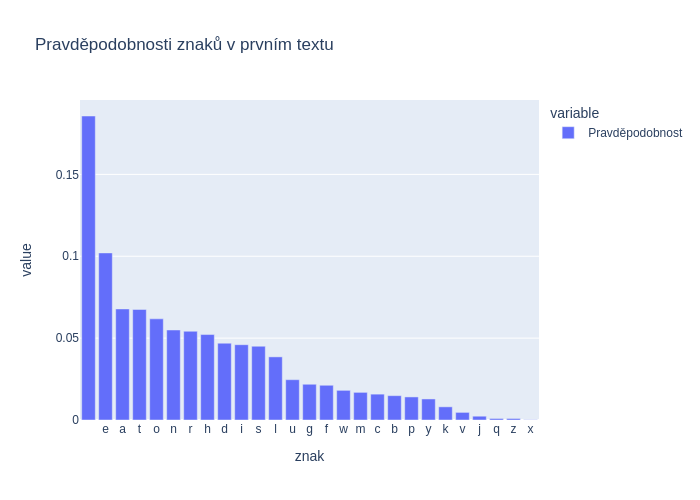

In [7]:
df_first['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v prvním textu")

Jak je vidět, tak znakem s největší pravděpodobností je mezera, následně znaky `e`, `a` a `t`. Nejméně pravděpodobné naopak byly znaky `q`, `z` a `x`.

Obdobně jsme zvizualizovali hodnoty pro druhý text.

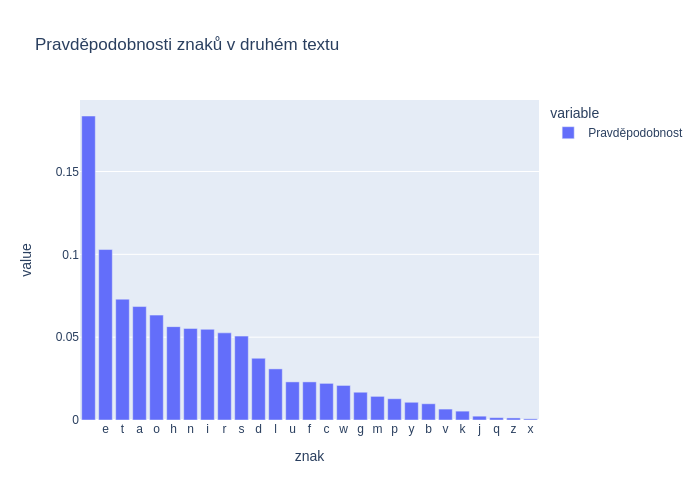

In [8]:
df_second['freq'].rename('Pravděpodobnost').plot(
    kind='bar', title="Pravděpodobnosti znaků v druhém textu")

Z grafu je vidět, že opět byla nejčastější mezera, hned po ní opět trojice `e`, `a`, `t` (v jiném pořadí) a nejméně četné byly opět znaky `q`,`z` a `x`.

Na základě této podobnosti jsme se rozhodli vykreslit graf pravděpodobností jednotlivých znaků pro oba texty. 

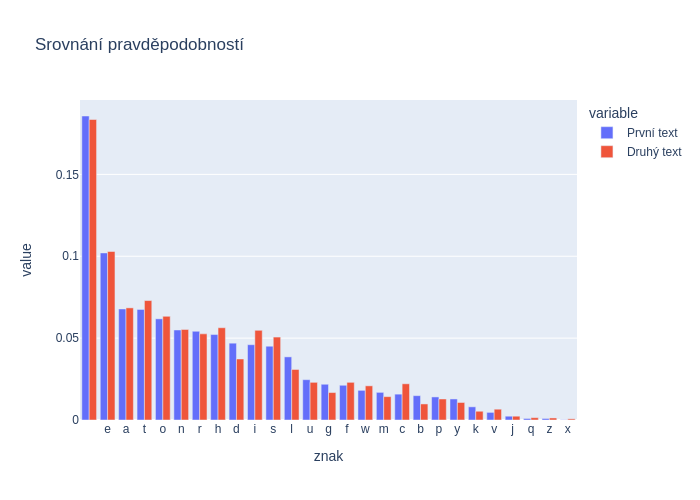

In [9]:
c = df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s')
c.columns = ['První text', 'Druhý text']
c.plot(kind='bar',title='Srovnání pravděpodobností', barmode="group")

Jak je vidět z grafu, sloupce pro oba texty jsou s menšími rozdíly velmi podobné. Rozhodli jsme se proto tedy spočíst korelaci mezi pravděpodobnostmi jednotlivých znaků.

#### Korelace pravděpodobností

In [10]:
df_first[['freq']].join(df_second[['freq']], lsuffix='_f', rsuffix='_s').corr().iloc[1, 0]

0.9945439587726614

Jak je vidět, tak pravděpodobnosti výskytů jednotlivých znaků v techtech je silně korelovaná.

---

## Matice přechodu


In [11]:
import plotly.express as px

def display_matrix(matrix, mapping, title=""):
    fig = px.imshow(matrix, x=mapping, y=mapping)

    fig.update_layout(title=title, margin = dict(t=200,r=200,b=200,l=200),
        showlegend = False,
        width = 800, height = 800,
        autosize = False )
    fig.show()

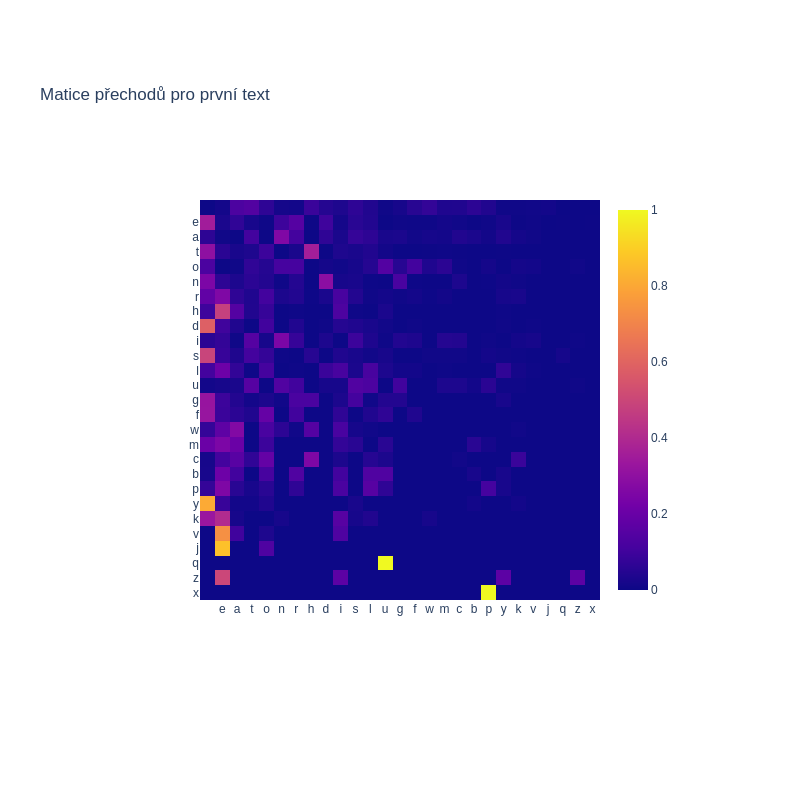

In [12]:
mapping = list(df_first.index.values)
inverse_mapping = {c:i for i,c in enumerate(mapping)}

A = np.zeros(shape=[len(mapping)]*2)

for i in range(len(first)-1):
    src = first[i]
    dest = first[i+1]
    A[inverse_mapping[src],inverse_mapping[dest]] += 1

A /= A.sum(axis=0)[:, None]

display_matrix(A, mapping, title="Matice přechodů pro první text")

In [13]:
sorted(filter( lambda x: x[0], [*zip(A[inverse_mapping['j']], mapping)]))

[(0.13333333333333333, 'o'), (0.8666666666666667, 'e')]

In [14]:
len([i for i in range(len(first)) if first[i:i+2]=='je']) / len([i for i in range(len(first)) if first[i]=='j'])

0.8666666666666667

---

## Nalezení stacionárního rozdělení prvního textu 

 Je-li množina stavů S konečná a matice přechodů A homogenní, pak stacionární rozdělení existuje.


$$
\pi \cdot \mathbf{P} = \pi \\
$$

Jelikož víme, že 
$$
\lim_{x\to\inf} \textit{row}_i(\mathbf{P}^{x}) = \pi
$$
jelikož ale pracujeme se strojovými čísly, bude tento výsledek přibližný.

In [15]:
P_n = np.linalg.matrix_power(A, 100000000000000)
pi=P_n[0]
pi

array([1.85835462e-01, 1.02139758e-01, 6.78865157e-02, 6.74215396e-02,
       6.18418260e-02, 5.50221760e-02, 5.42472157e-02, 5.22323192e-02,
       4.69625896e-02, 4.60326374e-02, 4.51026851e-02, 3.85930192e-02,
       2.46437352e-02, 2.18538783e-02, 2.12339102e-02, 1.81340693e-02,
       1.68941329e-02, 1.58091886e-02, 1.48792363e-02, 1.41042761e-02,
       1.28643397e-02, 8.05958634e-03, 4.64976135e-03, 2.32488067e-03,
       9.29952270e-04, 9.29952270e-04, 1.54992045e-04])

Ověříme-li, že opravdu platí $ \pi \cdot \mathbf{P} = \pi \\ $

In [16]:
np.equal(pi.T @ A, pi.T).all()

False

Všimneme si, že se levá strana rovnice nerovná té pravé, avšak pokud se podíváme na součet absolutních hodnot rozdílů jednotlivých složek obou stran

In [17]:
print(f"Chyba: {np.abs(pi.T @ A - pi.T).sum()}")


Chyba: 3.655116573991757e-16


zjistíme, že jsou si vektory opravdu blízké.

In [18]:
# zjistíme, jestli je chyba v toleranci (1e-8)
np.allclose(pi.T @ A, pi.T)

True

Přisuzujeme tedy tento rozdíl nepřesnostem při použití strojových čísel.

Další možností by bylo hledání stacionárního rozdělení za pomoci vlastních vektorů. 

Pokud se na rovnici 

$$ \pi \cdot \mathbf{P} = \pi \\ $$

podíváme trochu jinak, můžeme říct, že 

$$ \pi \cdot \mathbf{P} = \lambda\pi \\ $$

kde $\lambda$ je vlastní číslo rovné 1.

Za pomoci transponování matice přechodů dostaneme

$$ (\pi \cdot \mathbf{P})^\intercal = \lambda\pi^\intercal \\ $$

Což odpovídá

$$ (\mathbf{P}^\intercal \cdot \pi^\intercal  ) = \lambda\pi^\intercal \\ $$

Tudiž při hledání vlastních vektorů dostaneme levé vl. vektory $A^\intercal$, což jsou transponované vlastní vektory matice  $A$

In [19]:
# transponovanim dostaneme prave vlastni vektory
eigen_vals, eigen_vectors = np.linalg.eig(A.T) 

# vezmeme první vektor odpovídající vl. č. blízkému 1
eigen_vectors = eigen_vectors[:, np.isclose(eigen_vals, 1)][:, 0] 

In [20]:
np.allclose(eigen_vectors.T @ A, eigen_vectors.T)

True

Takový vlastní vektor již splňuje daný předpis

In [21]:
print(eigen_vectors)

[-6.67230382e-01+0.j -3.66726290e-01+0.j -2.43742208e-01+0.j
 -2.42072741e-01+0.j -2.22039134e-01+0.j -1.97553616e-01+0.j
 -1.94771171e-01+0.j -1.87536813e-01+0.j -1.68616185e-01+0.j
 -1.65277250e-01+0.j -1.61938316e-01+0.j -1.38565776e-01+0.j
 -8.84817604e-02+0.j -7.84649573e-02+0.j -7.62390011e-02+0.j
 -6.51092199e-02+0.j -6.06573074e-02+0.j -5.67618840e-02+0.j
 -5.34229496e-02+0.j -5.06405044e-02+0.j -4.61885919e-02+0.j
 -2.89374311e-02+0.j -1.66946718e-02+0.j -8.34733588e-03+0.j
 -3.33893435e-03+0.j -3.33893435e-03+0.j -5.56489059e-04+0.j]


Jelikož se má ale jednat o rozdělení, musíme přenormovat hodnoty.

In [22]:
pi2 = (eigen_vectors / eigen_vectors.sum()).real
print(pi2)

[1.85689949e-01 1.02059780e-01 6.78333591e-02 6.73687471e-02
 6.17934025e-02 5.49790925e-02 5.42047390e-02 5.21914202e-02
 4.69258169e-02 4.59965928e-02 4.50673687e-02 3.85628001e-02
 2.46244386e-02 2.18367663e-02 2.12172836e-02 1.81198699e-02
 1.68809044e-02 1.57968097e-02 1.48675856e-02 1.40932322e-02
 1.28542667e-02 8.05327551e-03 4.64612049e-03 2.32306024e-03
 9.29224098e-04 9.29224098e-04 1.54870683e-04]


In [23]:
np.allclose(pi2.T @ A, pi2.T)

True

Pokud se podíváme 

In [24]:
np.linalg.norm(pi),np.linalg.norm(pi2)

(0.27851768607322647, 0.27829960089646805)

Průměrný rozdíl hodnot složek

In [25]:
np.abs(pi - pi2).mean()

2.902350108591834e-05

---

## Test shody mezi stacionárním rozdělení $\pi$ a rozdělením znaků druhého textu 

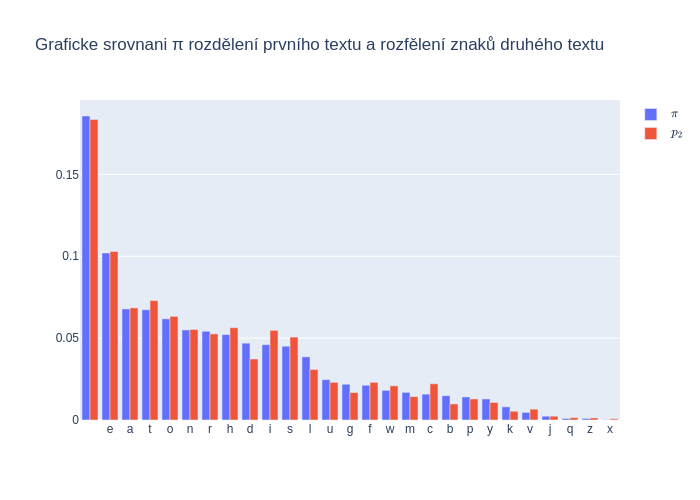

In [35]:
# mapping pro prvni a druhy nejsou stejne!
fig = go.Figure( data = [
go.Bar(x=mapping, y=pi2, name='$\pi$'),
go.Bar(x=df_second.index, y=df_second['freq'], name='$p_2$')])
fig.update_layout(title='Graficke srovnani π rozdělení prvního textu a rozfělení znaků druhého textu')


Nyní otestujeme hypotézu

$$ \mathcal{H}_0: \text{Rozdělení znaků druhého testu se rovná rozdělení }\pi $$ 


proti alternativě


$$ \mathcal{H}_A: \text{Rozdělení znaků druhého testu se nerovná rozdělení }\pi $$

Za pomoci $\chi^2$ testu.

Testujeme na hladině významnosti $\alpha = 5\%$, k čemuž použijeme párový ttest.

In [45]:
expected = list((df_second['counts'].sum() )* pi2)
print(expected) 

[1041.1635434412274, 572.2491869289138, 380.34164472665344, 377.7365649682517, 346.47560786743077, 308.2677714108719, 303.92597181353585, 292.6372928604615, 263.1130555985754, 257.9028960817717, 252.69273656496813, 216.22161994734412, 138.069227195292, 122.4387486448816, 118.9653089670126, 101.59811057766764, 94.65123122192976, 88.57271178565897, 83.36255226885561, 79.02075267151939, 72.07387331578131, 45.15471581229674, 26.050797584017342, 13.025398792008664, 5.210159516803464, 5.210159516803474, 0.868359919467243]


In [46]:
observed = list(df_first[['counts']].join(df_second[['counts']], rsuffix='_sec')['counts_sec'])
print(observed)

[1029, 577, 384, 409, 355, 310, 295, 316, 209, 307, 284, 173, 129, 94, 129, 117, 80, 124, 55, 72, 60, 30, 37, 13, 8, 7, 4]


In [47]:
expected[-2] += expected[-1]
observed[-2] += observed[-1]

In [48]:
expected = expected[:-1]
observed = observed[:-1]

In [49]:
from scipy.stats import chisquare
import scipy

dof = df_second.index.shape[0] - 1
chi2, p_value  = chisquare(observed, expected)
crit = scipy.stats.chi2.isf(0.05, dof)
print(f"Stupně volnosti: {dof}")
print(f"Testová statistika: {chi2}")
print(f"Kritický obor: {crit}")
print(f"p-hodnota: {p_value}")

Stupně volnosti: 26
Testová statistika: 92.42891125941313
Kritický obor: 38.88513865983007
p-hodnota: 1.1440904634206908e-09


In [38]:
chi2 >= crit

True

In [50]:
p_value < 0.05

True

Jelikož je testová statistika z kritického oboru hodnot a zároveň `p_hodnota` je menší než hladina významnosti (`5%`), zamítáme hypotézu \mathcal{H}_0 ve prospěch alternativy \mathcal{H}_A, která vyšla statisticky velmi významná (pravděpodobnost chyby 1. druhu je menší než `1.15e-9` )